In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

import torch
from torch import nn
from torch.nn.init import calculate_gain

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [4]:
from models.MLP import Davies2021
net = Davies2021(N_layers=8, width=28, activation=nn.Softplus(30), last_activation=nn.Softplus(30)).to(device)
#net = Davies2021(N_layers=8, width=28, activation=nn.SiLU(), last_activation=nn.Identity()).to(device)


In [6]:
import os
from utils.dataset_generator import ImplicitDataset

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
print(train_dataset)

# filter out discontinous points
grads = train_dataset.grads
norm_grad = torch.linalg.norm(grads, dim=1)
mark = torch.logical_and(norm_grad > 0.9, norm_grad < 1.05)
grads = grads[mark]
points = train_dataset.points[mark]
sdfs = train_dataset.sdfs[mark]

ImplicitDataset (64000 points)


In [8]:
from utils.callback_scheduler import CallbackScheduler

# Optimization
## ADA
torch.nn.utils.clip_grad_norm_(net.parameters(), 10.0)
optimizer=torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.init_LBFGS(
        lr=1, max_iter=30, max_eval=60, 
        tolerance_grad=1e-5, tolerance_change=1e-9,
        history_size=100,
        line_search_fn=None
    ),
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [9]:
max_epochs = 5000
PRINT_EVERY_EPOCH = 100

#points.requires_grad_(True)
try:
    epoch = 0
    while epoch < max_epochs:
        #for points, sdfs in batch_loader(train_dataset.points, train_dataset.sdfs, batch_size=20000):
            # Training
            lr_scheduler.optimizer.zero_grad()
            #points.requires_grad_(True)
            loss = net.loss(points, sdfs)
            loss.backward()

            lr_scheduler.optimizer.step(lambda: loss)
            lr_scheduler.step_when((epoch % 500) == 499, verbose=True)
            if epoch % PRINT_EVERY_EPOCH == 0:
                print(f'#{epoch} Loss: {net._loss:.6f}')

            epoch += 1
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 0.015724
#100 Loss: 0.001084
#200 Loss: 0.000758
#300 Loss: 0.000704
#400 Loss: 0.000802
Learning rate changed
#500 Loss: 0.000677
#600 Loss: 0.000655
#700 Loss: 0.000648
#800 Loss: 0.000637
#900 Loss: 0.000618
Learning rate changed
#1000 Loss: 0.000577
#1100 Loss: 0.000567
#1200 Loss: 0.000556
#1300 Loss: 0.000546
#1400 Loss: 0.000535
Learning rate changed
#1500 Loss: 0.000522
#1600 Loss: 0.000519
#1700 Loss: 0.000516
#1800 Loss: 0.000513
#1900 Loss: 0.000510
Learning rate changed
#2000 Loss: 0.000506
#2100 Loss: 0.000376
#2200 Loss: 0.000288
#2300 Loss: 0.000214
#2400 Loss: 0.000168
Learning rate changed
#2500 Loss: 0.000140
#2600 Loss: 0.000119
#2700 Loss: 0.000104
#2800 Loss: 0.000092
#2900 Loss: 0.000084
Learning rate changed
#3000 Loss: 0.000078
#3100 Loss: 0.000073
#3200 Loss: 0.000069
#3300 Loss: 0.000065
#3400 Loss: 0.000062
Learning rate changed
#3500 Loss: 0.000060
#3600 Loss: 0.000057
#3700 Loss: 0.000055
#3800 Loss: 0.000054
#3900 Loss: 0.000052
Learning rate chan

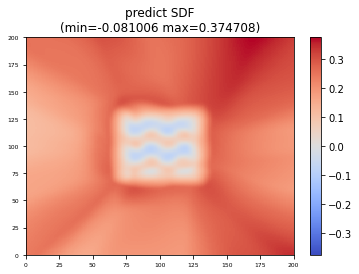

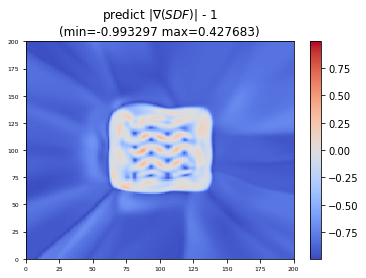

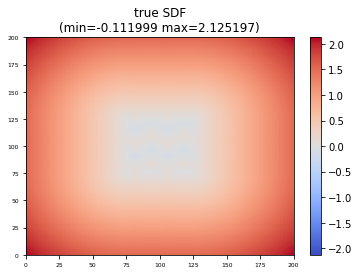

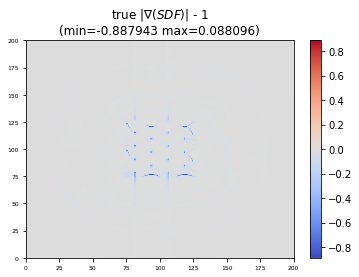

In [11]:
from utils.visualizer import SDFVisualize
net.to(device)
visualize = SDFVisualize(z_level=0.0, step=0.05, offset=50, nums=200, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)

In [12]:
from utils.dataset_generator import TestDataset
test_dataset = TestDataset(dataset_name+'_test.npz', device=device)
print('Uniform SDFS: ', net.test(test_dataset.uniform.points, test_dataset.uniform.sdfs).cpu().detach().numpy())
print('Random SDFS:', net.test(test_dataset.random.points, test_dataset.random.sdfs).cpu().detach().numpy())
print('Outside SDFS:', net.test(test_dataset.outside.points, test_dataset.outside.sdfs).cpu().detach().numpy())
print('Train residual: ', net.test_residual(train_dataset.points).cpu().detach().numpy())
print('Uniform gradient: ', net.test_gradient(test_dataset.uniform.points, test_dataset.uniform.gradients).cpu().detach().numpy())
print('Uniform residual: ', net.test_residual(test_dataset.uniform.points).cpu().detach().numpy(), net.test_residual(test_dataset.random.points).cpu().detach().numpy())
print('Actual Uniform residual: ', torch.mean((test_dataset.uniform.gradients - 1)**2).cpu().detach().numpy())

Uniform SDFS:  0.00012279267
Random SDFS: 0.000934811
Outside SDFS: 0.3718418
Train residual:  0.18056047
Uniform gradient:  0.10186503
Uniform residual:  0.2670348 0.223457
Actual Uniform residual:  0.0100825215
